In [1]:
import numpy as np
import pandas as pd
import sqlite3

import matplotlib.pyplot as plt

import seaborn as sns

import regex as re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import nltk
try:
        nltk.load('wordnet')
        nltk.load('omw-1.4')
except: # If not present, we download
        nltk.download('wordnet')
        nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
from nltk import word_tokenize




[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dakot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dakot\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dakot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df_raw = pd.read_csv('database/IMDB Dataset.csv')
df_raw.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


C:\Users\dakot\anaconda3\envs\youtube_nlp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

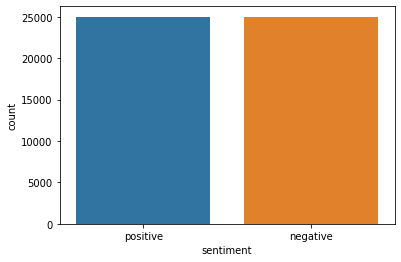

In [3]:
sns.countplot(df_raw.sentiment)

In [4]:
lemmatizer=WordNetLemmatizer()

def documentProcessor(df_column):
    corpus=[]

    addStopWords = ['movie','film','one','show']
    my_stop_words=stopwords.words('english')
    my_stop_words.extend(addStopWords)
    
    for document in df_column:
        documentProcessed=re.sub('[^a-zA-Z]', ' ', str(document))
        documentProcessed=documentProcessed.lower()
        documentProcessed=documentProcessed.split()
        documentProcessed=[lemmatizer.lemmatize(word, 'v') for word in documentProcessed if word not in my_stop_words and len(word)>2]
        corpus.append(' '.join(str(word) for word in documentProcessed))
    return corpus



In [5]:
lemmatizer.lemmatize('running','v')

'run'

In [6]:
corpus=documentProcessor(df_raw['review'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dakot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dakot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


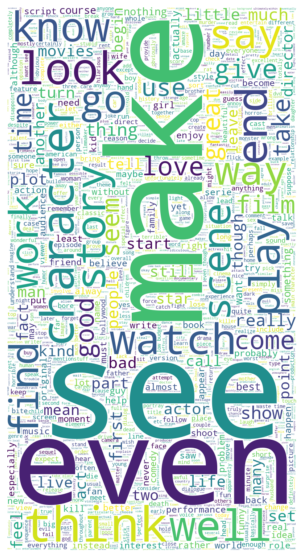

In [7]:
#construct a wordcloud to visualize the distribution of descriptor words in the "description" feature. This is used create new
#features in the data cleaning script

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#add words from the home description feature to the list of words to be used in the cloud
words=" ".join(corpus)

#define stop/break words for word cloud function
def punctuation_stop(text):
    filtered=[]
    stop_words=set(stopwords.words("english"))
    word_tokens=word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered
words_filtered=punctuation_stop(words)

#Define words that should not be included in the word cloud
unwanted=[]

text=" ".join([ele for ele in words_filtered if ele not in unwanted])

#call word cloud function and generate plot
wc=WordCloud(background_color="white", stopwords=STOPWORDS, max_words=2000, width=800,height=1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [8]:

ctVectorizer=CountVectorizer(ngram_range=(1,2), max_features = 2500)
vectorizedData=ctVectorizer.fit_transform(corpus).toarray()



In [9]:
X=vectorizedData
y=df_raw.sentiment.values

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
GNBmodel = GaussianNB()
print(np.mean(cross_val_score(GNBmodel, X, y, cv=3)))

0.7896998822294045


In [11]:
from sklearn.ensemble import RandomForestClassifier

RFmodel=RandomForestClassifier()

print(np.mean(cross_val_score(RFmodel, X, y, cv=3)))

0.8410999834725494


Elapsed time to compute the importances: 0.069 seconds


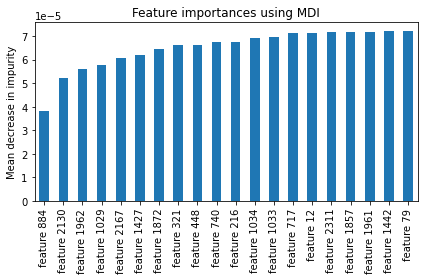

In [13]:
RFmodel.fit(X,y)

feature_names = [f"feature {i}" for i in range(X.shape[1])]

import time
import numpy as np

start_time = time.time()
importances = RFmodel.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFmodel.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)
forest_importances=forest_importances.sort_values(ascending=True)
forest_importances=forest_importances.head(20)

fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
from sklearn.svm import LinearSVC

SVCmodel=LinearSVC(random_state=1, dual=False)

print(np.mean(cross_val_score(SVCmodel, X, y, cv=3)))

0.8701999918959978


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)

In [ ]:
SVCmodel.fit(X_train, y_train)
y_predicted=SVCmodel.predict(X_test)

[[4410  634]
 [ 540 4416]]
Accuracy:  0.8826


<AxesSubplot:>

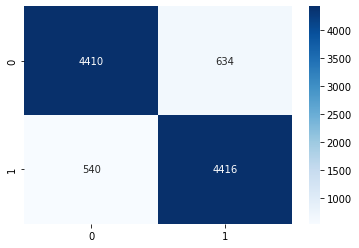

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy = accuracy_score(y_test, y_predicted)
conMat = confusion_matrix(y_test, y_predicted)
print(conMat)
print("Accuracy: ", accuracy )

labels=["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conMat, fmt="", annot=labels, cmap='Blues', annot=True)